In [14]:
import numpy as np

def process_data(data,mean=None,std=None):
    # normalize the data to have zero mean and unit variance (add 1e-15 to std to avoid numerical issue)
    if mean is not None:
        # mean and std is precomputed with the training data
        norm_data = (data - mean)/(std + 1e-15)
        return norm_data
    else:
        # compute the mean and std based on the training data
        mean = std = 0 # placeholder
        mean = np.mean(data, axis=0) # mean col-wise
        std = np.std(data, axis=0) # std col-wise with 1e-15 added
        
        norm_data = (data - mean)/(std + 1e-15)
        
        return norm_data, mean, std

def process_label(label):
    # convert the labels into one-hot vector for training
    one_hot = np.zeros([len(label),10])
    for i in range(0,len(label)):
        for j in range(0,10):
            if j == label[i]:
                one_hot[i][j] = 1
            else:
                one_hot[i][j] = 0 
    return one_hot

def tanh(x):
    # implement the tanh activation function for hidden layer
    #f_x = (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
    # implement the hyperbolic tangent activation function for hidden layer
    # You may receive some warning messages from Numpy. No worries, they should not affect your final results
    f_x = np.tanh(x)

    return f_x

def softmax(x):
    # implement the softmax activation function for output layer
    val = np.exp(x)
    f_x = val / val.sum()
    
    return f_x

class MLP:
    def __init__(self,num_hid):
        # initialize the weights
        self.weight_1 = np.random.random([64,num_hid]) #w
        self.bias_1 = np.random.random([1,num_hid]) #w0
        self.weight_2 = np.random.random([num_hid,10]) #v
        self.bias_2 = np.random.random([1,10]) #v0
        self.num_hid = num_hid #added

    def fit(self,train_x,train_y, valid_x, valid_y):
        # learning rate
        lr = 5e-3
        # counter for recording the number of epochs without improvement
        count = 0
        best_valid_acc = 0

        """
        Stop the training if there is no improvment over the best validation accuracy for more than 100 iterations
        """
        while count<=100:
            # training with all samples (full-batch gradient descents)
            # implement the forward pass
            zh = self.get_hidden(train_x)
            y = process_label(self.predict(train_x))
            
            rmy = train_y - y #get r_i minus y_i
            z_der = zh * (1 - zh) #derivative of z
            
            # implement the backward pass (backpropagation)
            # compute the gradients w.r.t. different parameters
            #get delta v
            delta_v = lr * np.dot(zh.T, rmy) #num_hidx10
            delta_v_bias = lr * np.sum(rmy, axis=0)
            
            #get delta_w
            rmy_v = np.dot(rmy,self.weight_2.T)
            prod = (rmy_v*z_der)
            delta_w = lr * np.dot(prod.T,train_x) #num_hidx64, need to transpose when updating
            
            delta_w_bias = lr* np.sum(prod, axis=0) 
            
            #update the parameters based on sum of gradients for all training samples
            self.weight_2 = self.weight_2 + delta_v  #update weight
            self.weight_1 = self.weight_1 + delta_w.T #update weight
            self.bias_2 = self.bias_2 + delta_v_bias  #update bias
            self.bias_1 = self.bias_1 + delta_w_bias #update bias
            
            # evaluate on validation data
            predictions = self.predict(valid_x)
            valid_acc = np.count_nonzero(predictions.reshape(-1)==valid_y.reshape(-1))/len(valid_x)

            # compare the current validation accuracy with the best one
            if valid_acc>best_valid_acc:
                best_valid_acc = valid_acc
                count = 0
            else:
                count += 1

        return best_valid_acc

    def predict(self,x):
        # generate the predicted probability of different classes
        # convert class probability to predicted labels
        
        zh = self.get_hidden(x)
        
        #get o and y
        ot = np.dot(self.weight_2.T,zh.T).T + self.bias_2
        
        y = softmax(ot)
        y_prob = np.argmax(y, axis=1)

            
        return y_prob

    def get_hidden(self,x):
        # # extract the intermediate features computed at the hidden layers (after applying activation function)
        w_T = self.weight_1.T # w transpose
        w_bias = self.bias_1.T
           
        zh=[]
        for t in range(len(x)): #for each sample in x
            #get z using sigmoid    
            z=[]   
            for h in range(self.num_hid): #for each hidden layer
                wtx = np.dot(w_T[h], x[t].T) + w_bias[h]
                z.append(wtx) 
            z=np.asarray(z)
            z_sig = tanh(z) # lenx X num_hid
            zh.append(z_sig)
            
        zh = np.asarray(zh).reshape(len(x),self.num_hid) 
        return zh

    def params(self):
        return self.weight_1, self.bias_1, self.weight_2, self.bias_2, self.num_hid

In [15]:
from matplotlib import pyplot as plt
import numpy as np

# recommended color for different digits
color_mapping = {0:'red',1:'green',2:'blue',3:'yellow',4:'magenta',5:'orangered',
                6:'cyan',7:'purple',8:'gold',9:'pink'}

def plot2d(data,label,split='train'):
    #2d scatter plot of the hidden features
    color_keys = color_mapping.keys() #0-9
    
    fig = plt.figure()
    for c in color_keys: 
        for m in range(len(label)):
                if label[m] == c:
                    plt.plot(data[m,0], data[m,1],'o', color=color_mapping[c], alpha=0.4)      
        plt.plot(data[c], data[c],'o', color=color_mapping[c], label="Class "+ np.str(c), alpha=0.6)
    
    fig.set_size_inches(7, 7)
    plt.title('the intermediate features computed at the hidden layers for ' + split + ' set in 2D')        
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()


def plot3d(data,label,split='train'):
    # 3d scatter plot of the hidden features
    
    color_keys = color_mapping.keys() #0-9

    fig = plt.figure()  
    ax = fig.add_subplot(projection='3d')
    
    for c in color_keys: 
        for m in range(len(label)):
            if label[m] == c:
                ax.scatter(data[m,0], data[m,1], data[m,2], 'o', color=color_mapping[c], alpha=0.4)
        ax.scatter(data[c], data[c], data[c],'o', color=color_mapping[c], label="Class "+ np.str(c), alpha=0.6)
    fig.set_size_inches(7, 7)
    ax.legend(bbox_to_anchor=(1.05,0.8))
    ax.set_title(label='the intermediate features computed at the hidden layers for ' + split + ' set in 3D')
    plt.show()

Validation accuracy for 4 hidden units is 0.195
Validation accuracy for 8 hidden units is 0.237
Validation accuracy for 16 hidden units is 0.233
Validation accuracy for 20 hidden units is 0.258
Validation accuracy for 24 hidden units is 0.261
Test accuracy with 24 hidden units is 0.149


C:\Users\DINESH~1.AVM\AppData\Local\Temp/ipykernel_1312/482592201.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(data[c], data[c],'o', color=color_mapping[c], label="Class "+ np.str(c), alpha=0.6)
C:\Users\DINESH~1.AVM\AppData\Local\Temp/ipykernel_1312/482592201.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(data[c], data[c],'

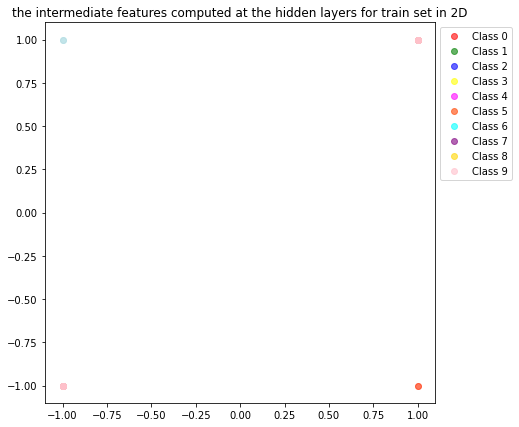

C:\Users\DINESH~1.AVM\AppData\Local\Temp/ipykernel_1312/482592201.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(data[c], data[c],'o', color=color_mapping[c], label="Class "+ np.str(c), alpha=0.6)
C:\Users\DINESH~1.AVM\AppData\Local\Temp/ipykernel_1312/482592201.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(data[c], data[c],'

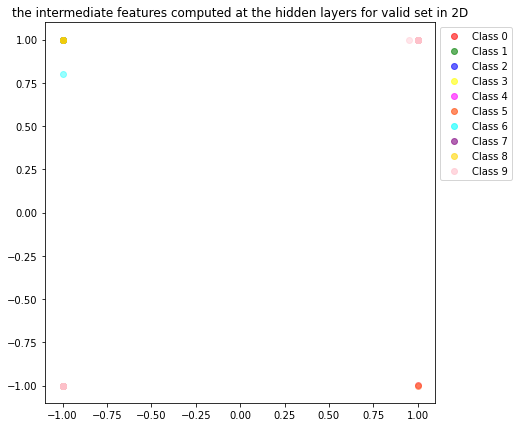

C:\Users\DINESH~1.AVM\AppData\Local\Temp/ipykernel_1312/482592201.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(data[c], data[c],'o', color=color_mapping[c], label="Class "+ np.str(c), alpha=0.6)
C:\Users\DINESH~1.AVM\AppData\Local\Temp/ipykernel_1312/482592201.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.plot(data[c], data[c],'

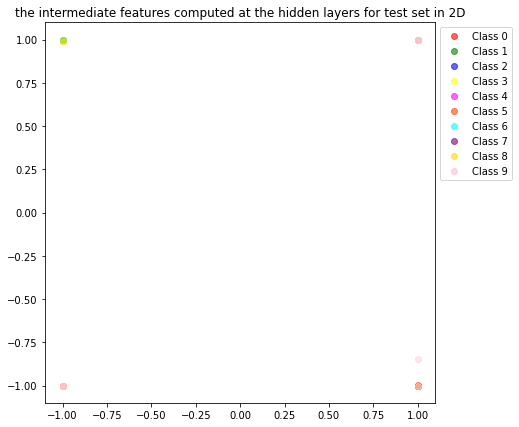

In [ ]:
# read in data.
# training data
train_data = np.genfromtxt("optdigits_train.txt",delimiter=",")
train_x = train_data[:,:-1]
train_y = train_data[:,-1].astype('int')

# validation data
valid_data = np.genfromtxt("optdigits_valid.txt",delimiter=",")
valid_x = valid_data[:,:-1]
valid_y = valid_data[:,-1].astype('int')

# test data
test_data = np.genfromtxt("optdigits_test.txt",delimiter=",")
test_x = test_data[:,:-1]
test_y = test_data[:,-1].astype('int')

# normalize the data
train_x, mean, std = process_data(train_x)
valid_x = process_data(valid_x, mean, std)
test_x = process_data(test_x, mean, std)

# process training labels into one-hot vectors
train_y = process_label(train_y)

# ############### Problem a ###################
# experiment with different numbers of hidden units
candidate_num_hid = [4,8,16,20,24]
valid_accuracy = []
for i, num_hid in enumerate(candidate_num_hid):
    # initialize the model
    clf = MLP(num_hid=num_hid)
    # update the model based on training data, and record the best validation accuracy
    cur_valid_accuracy = clf.fit(train_x,train_y,valid_x,valid_y)
    valid_accuracy.append(cur_valid_accuracy)
    print('Validation accuracy for %d hidden units is %.3f' %(candidate_num_hid[i],cur_valid_accuracy))

# select the best number of hidden unit and use it to train the model
best_num_hid = candidate_num_hid[np.argmax(valid_accuracy)]
clf = MLP(num_hid=best_num_hid)
_ = clf.fit(train_x,train_y,valid_x,valid_y)

# evaluate on test data
predictions = clf.predict(test_x)
accuracy = np.count_nonzero(predictions.reshape(-1)==test_y.reshape(-1))/len(test_x)

print('Test accuracy with %d hidden units is %.3f' %(best_num_hid,accuracy))


############### Problem b ###################
# visualization for 2 hidden units
clf = MLP(num_hid=2)
_ = clf.fit(train_x,train_y,valid_x,valid_y)
# training set visualization
hid_features = clf.get_hidden(train_x)
plot2d(hid_features,np.argmax(train_y,axis=-1),'train')
# validation set visualization
hid_features = clf.get_hidden(valid_x)
plot2d(hid_features,valid_y,'valid')
# test set visualization
hid_features = clf.get_hidden(test_x)
plot2d(hid_features,test_y,'test')


# # visualization for 3 hidden units
clf = MLP(num_hid=3)
_ = clf.fit(train_x,train_y,valid_x,valid_y)
# training set visualization
hid_features = clf.get_hidden(train_x)
plot3d(hid_features,np.argmax(train_y,axis=-1),'train')
# validation set visualization
hid_features = clf.get_hidden(valid_x)
plot3d(hid_features,valid_y,'valid')
# test set visualization
hid_features = clf.get_hidden(test_x)
plot3d(hid_features,test_y,'test')